# Import

In [1]:
# System
import os
import json

# Data processing
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler

# Plot
import matplotlib.pyplot as plt

# ML
    # pytorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, StepLR
torch.set_num_threads(4) # Processor Setting
    # VAR
from statsmodels.tsa.api import VAR as var_model
    # ESN
from scipy import linalg
import scipy
from sklearn.linear_model import Ridge

# Config

In [2]:
# Config path
root = '/Volumes/Expansion/User_Backup/b08209033/111-2_IVT_analysis/'
file = 'config.json'
config_path = os.path.join(root, file)

# Import config
with open(config_path) as infile:
    config = json.load(infile)
    infile.close()

# Update config
    # ML Parameters
        # DataLoader
config.update({"ML_hyperparam_lookback": 1})
config.update({"ML_hyperparam_batch_size": 32})
        # Epoch
config.update({"ML_hyperparam_nepochs": 200})
config.update({"ML_hyperparam_early_stop": 30})
config.update({"ML_hyperparam_forecast_step": 90})
        # optim
config.update({"ML_hyperparam_learning_rate": 5e-4})
config.update({"ML_hyperparam_weight_decay": 3e-6})
    # ML Fpath
config.update({"ML_path_model": os.path.join(config["Path_root"], "models")})
config.update({"ML_fname_model": "model.pt"})

# Export config
with open(config_path, 'w') as outfile:
    json.dump(config, outfile, sort_keys=True)
    outfile.close()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# DataLoader

In [4]:
def getDataLoader(train_set, valid_set, test_set, config):
    
    # Split, Train set
    train_len = config["ML_split_size"][0] - config["ML_hyperparam_lookback"]
    X_train = np.zeros((train_len, config["ML_hyperparam_lookback"], train_set.shape[-1]))
    Y_train = np.zeros((train_len,                                1, train_set.shape[-1]))
    for i in range(train_len):
        X_train[i,:,:] = train_set[i:i+config["ML_hyperparam_lookback"],:]
        Y_train[i,:,:] = train_set[i+config["ML_hyperparam_lookback"],  :].reshape(1, -1)
    
    # Split, Valid set
    valid_len = config["ML_split_size"][1] - config["ML_hyperparam_lookback"]
    X_valid = np.zeros((valid_len, config["ML_hyperparam_lookback"], valid_set.shape[-1]))
    Y_valid = np.zeros((valid_len,                                1, valid_set.shape[-1]))
    for i in range(valid_len):
        X_valid[i,:,:] = valid_set[i:i+config["ML_hyperparam_lookback"],:]
        Y_valid[i,:,:] = valid_set[i+config["ML_hyperparam_lookback"],  :].reshape(1, -1)
    
    # Split, Test set
    test_len = config["ML_split_size"][2] - config["ML_hyperparam_lookback"]
    X_test = np.zeros((test_len, config["ML_hyperparam_lookback"], test_set.shape[-1]))
    Y_test = np.zeros((test_len,                                1, test_set.shape[-1]))
    for i in range(test_len):
        X_test[i,:,:] = test_set[i:i+config["ML_hyperparam_lookback"],:]
        Y_test[i,:,:] = test_set[i+config["ML_hyperparam_lookback"]  ,:].reshape(1, -1)
        
    # To Tensor
    X_train = torch.from_numpy(X_train)
    Y_train = torch.from_numpy(Y_train)
    X_valid = torch.from_numpy(X_valid)
    Y_valid = torch.from_numpy(Y_valid)
    X_test  = torch.from_numpy(X_test)
    Y_test  = torch.from_numpy(Y_test)
    
    # To Dataset
    train_data = TensorDataset(X_train, Y_train)
    valid_data = TensorDataset(X_valid, Y_valid)
    test_data  = TensorDataset(X_test,  Y_test)
    
    # To DataLoader
    train_loader = DataLoader(train_data, 
                              batch_size = config["ML_hyperparam_batch_size"],
                              shuffle = False,
                              pin_memory = True)
    valid_loader = DataLoader(valid_data, 
                              batch_size = config["ML_hyperparam_batch_size"],
                              shuffle = False,
                              pin_memory = True)
    test_loader  = DataLoader(test_data, 
                              batch_size = config["ML_hyperparam_batch_size"],
                              shuffle = False,
                              pin_memory = True)
    return train_loader, valid_loader, test_loader

In [5]:
# Read dataset
os.chdir(config["Path_IVT_calculation"])
with np.load(config["ML_fname_dataset"]) as dataset:
    train_set = dataset["train"]
    valid_set = dataset["valid"]
    test_set  = dataset["test"]
# To DataLoader
train_loader, valid_loader, test_loader = getDataLoader(train_set, valid_set, test_set, config)

# GRU

In [6]:
class GatedRecurrentUnit(object):
    """
    Model: User defined
    Implement training, validating, testing, and forecasting process
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers, device):
        """
        Constructor
        """
        self.device = device
        self.model = pytorch_GRU_FC(input_size  = input_size,
                                    hidden_size = hidden_size,
                                    output_size = output_size,
                                    num_layers  = num_layers).to(self.device).double()
        return None
    
    def trainer(self, train_loader, valid_loader, config):
        """
        Training model from given dataloader and parameter setting
        """
        # Initialization
            # Epoch
        n_epochs, step, early_stop_count = config['ML_hyperparam_nepochs'], 0, 0
            # Loss function
        best_loss = math.inf
        criterion = nn.MSELoss(reduction='mean').to(self.device)
        mean_train_loss_record = []
        mean_valid_loss_record = []
            # Optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), 
                                     lr = config['ML_hyperparam_learning_rate'], 
                                     weight_decay = config['ML_hyperparam_weight_decay'])
            # Scheduler
        scheduler_CAWR = CosineAnnealingWarmRestarts(optimizer, 
                                                     T_0     = 50, 
                                                     T_mult  = 5, 
                                                     eta_min = config['ML_hyperparam_weight_decay']/1e4)
        # Training & Validating stage
        for epoch in range(n_epochs):
        # Training
            self.model.train()
            loss_record = []
            for (x, y) in train_loader:
                optimizer.zero_grad()
                x, y = x.to(self.device), y.to(self.device)
                pred = self.model(x)
                loss = criterion(pred[:,-1,:], y[:,-1,:])
                loss.backward()
                optimizer.step()
                step += 1
                loss_record.append(loss.detach().item())
            scheduler_CAWR.step()
            mean_train_loss_record.append(sum(loss_record)/len(loss_record))
        # Validating
            self.model.eval()
            loss_record = []
            for (x, y) in valid_loader:
                with torch.no_grad():
                    x, y = x.to(self.device), y.to(self.device)
                    pred = self.model(x)
                    loss = criterion(pred[:,-1,:], y[:,-1,:])
                loss_record.append(loss.item())
            mean_valid_loss_record.append(sum(loss_record)/len(loss_record))
        # Evaluating stage
            # Show error evolution
            if (epoch%10==0):
                print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss_record[-1]:.7f}, Valid loss: {mean_valid_loss_record[-1]:.7f}')
            # Save model
            if mean_valid_loss_record[-1] < best_loss:
                best_loss = mean_valid_loss_record[-1]
                os.chdir(config["ML_path_model"])
                torch.save(self.model, config["ML_fname_model"])
                early_stop_count = 0
            else: 
                early_stop_count += 1
            # Early stop
            if early_stop_count >= config['ML_hyperparam_early_stop']:
                print('\nModel is not improving, so we halt the training session.')
                return mean_train_loss_record, mean_valid_loss_record

        return mean_train_loss_record, mean_valid_loss_record
    
    def tester(self, test_loader, config):
        """
        Testing model from given dataloader and parameter setting
        """
        # Initialization
            # Model
        os.chdir(config["ML_path_model"])
        best_model = torch.load(config["ML_fname_model"])
            # Storage array
        predict = np.array([]).reshape(-1, config["Var_Feature_num_SVD"]+config["Flag_timeline_feature"])
        truth   = np.array([]).reshape(-1, config["Var_Feature_num_SVD"]+config["Flag_timeline_feature"])
        # Testing
        for i, (x, y) in enumerate(test_loader):
            x = x.to(self.device)
            y = y.to(self.device)
            with torch.no_grad():
                pred    = best_model(x)
                predict = np.concatenate((predict, pred.detach().cpu().numpy()[:,-1,:]), axis = 0)
                truth   = np.concatenate((  truth,    y.detach().cpu().numpy()[:,-1,:]), axis = 0)
        return predict, truth
    
    def forecaster(self, init_state, ntime, momentum = np.array([0, 1])):
        """
        Consecutive prediction from given initial state and timestep
        Momentum: the random forcing process (stirring)
        This implement a forecast - forcing cycle
        """
        # Initialization
            # Model
        os.chdir(config["ML_path_model"])
        best_model = torch.load(config["ML_fname_model"])
            # IC
        current_state = torch.from_numpy(init_state).to(self.device)
            # Storage array
        forecast = torch.reshape(torch.tensor([]), (0, current_state.size()[-1]))
        # Forecasting stage (forecast - forcing cycle)
        with torch.no_grad():
            for i in range(ntime):
                # forecast 
                pred = best_model(current_state)
                forecast = torch.cat((forecast, pred[:,-1,:]), axis = 0)
                # forcing
                eta = torch.normal(torch.from_numpy(momentum[0]), torch.from_numpy(momentum[1])).reshape(1, -1)
                current_state = torch.cat((current_state[:,1:,:], pred + eta), axis = 1)
        forecast = forecast.detach().numpy()
        return forecast
    
class pytorch_GRU_FC(nn.Module):
    """
    Implement model structure setting
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        """
        Constructor
        """
        super(pytorch_GRU_FC, self).__init__()
        # Parameter
        self.input_length = input_size
        self.num_layers = num_layers
        self.hidden_dim = hidden_size
        # Structure
        self.GRU = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.FC = nn.Linear(hidden_size, output_size)
        # Weight init
        self.GRU.weight_ih_l0.data.fill_(0)
        self.GRU.weight_hh_l0.data.fill_(0)
        self.FC.weight.data.fill_(0)
    def forward(self, x):
        """
        Passing input into model
        """
        # Hidden init
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_dim, dtype = torch.double).requires_grad_()
        # GRU pass
        out, (hn) = self.GRU(x, (h0.detach()))
        # FC pass
        out = self.FC(out[:, -1, :])
        # Output
        out = torch.reshape(out, (out.size()[0], 1, out.size()[-1]))
        return out

In [7]:
# Init
GRU = GatedRecurrentUnit(input_size  = train_set.shape[-1], 
                         hidden_size = 100, 
                         output_size = train_set.shape[-1], 
                         num_layers  = 1,
                         device      = device)
# Train
train_loss_record, valid_loss_record = GRU.trainer(train_loader = train_loader, 
                                                   valid_loader = valid_loader, 
                                                   config       = config)
# Test
GRU_predict, GRU_truth = GRU.tester(test_loader = test_loader, 
                                    config      = config)
# Forecast
    # Forcing, random process
random_process_forcing  = GRU_predict - GRU_truth
random_process_momentum = np.array([np.mean(random_process_forcing, axis = 0), 
                                    np.std(random_process_forcing, axis = 0)])
    # IC
GRU_IC = test_set[0:config["ML_hyperparam_lookback"],:]
GRU_IC = GRU_IC.reshape(1, config["ML_hyperparam_lookback"], -1)
    # forecast
GRU_forecast = GRU.forecaster(init_state = GRU_IC, 
                              ntime      = config["ML_hyperparam_forecast_step"], 
                              momentum   = random_process_momentum)

Epoch [1/200]: Train loss: 0.0388496, Valid loss: 0.0769556
Epoch [11/200]: Train loss: 0.0148087, Valid loss: 0.0292154
Epoch [21/200]: Train loss: 0.0143910, Valid loss: 0.0280408
Epoch [31/200]: Train loss: 0.0141938, Valid loss: 0.0276754
Epoch [41/200]: Train loss: 0.0140712, Valid loss: 0.0274876
Epoch [51/200]: Train loss: 0.0142172, Valid loss: 0.0275408
Epoch [61/200]: Train loss: 0.0137979, Valid loss: 0.0267781
Epoch [71/200]: Train loss: 0.0133246, Valid loss: 0.0261677
Epoch [81/200]: Train loss: 0.0129709, Valid loss: 0.0257832
Epoch [91/200]: Train loss: 0.0127157, Valid loss: 0.0255535
Epoch [101/200]: Train loss: 0.0125217, Valid loss: 0.0254115
Epoch [111/200]: Train loss: 0.0123684, Valid loss: 0.0253161
Epoch [121/200]: Train loss: 0.0122441, Valid loss: 0.0252458
Epoch [131/200]: Train loss: 0.0121414, Valid loss: 0.0251891
Epoch [141/200]: Train loss: 0.0120551, Valid loss: 0.0251412
Epoch [151/200]: Train loss: 0.0119815, Valid loss: 0.0251001
Epoch [161/200]: Tr

# VAR

In [8]:
class VarAutoReg(object):
    """
    Model: Variational AutoRegressive
    Implement training, testing, and forecasting process
    """
    def __init__(self, train_data):
        """
        Constructor
        """
        self.train_data = train_data
        self.VAR        = var_model(self.train_data)
        return None
    
    def trainer(self, time_lags, trend_type):
        """
        Training model from given parameter setting
        """
        self.AR_p      = time_lags
        self.trend     = trend_type
        self.VARResult = self.VAR.fit(maxlags = self.AR_p, trend = self.trend)
        return None
    def tester(self, test_data, config):
        """
        Testing model from given parameter setting
        """
        self.test_data = test_data
        # Initialization
        predict = []
        truth = []
        # Testing
        available_test_len = len(self.test_data) - config["ML_hyperparam_lookback"]
        for i in range(available_test_len):
            x = self.test_data[i:i+config["ML_hyperparam_lookback"],:]
            x = x.reshape(config["ML_hyperparam_lookback"], -1)
            y = self.test_data[i+config["ML_hyperparam_lookback"],:]
            y = y.reshape(1,-1)
            pred = self.VARResult.forecast(x, 1)
            predict.append(pred)
            truth.append(y)
        predict = np.array(predict).reshape(-1, self.test_data.shape[-1])
        truth = np.array(truth).reshape(-1, self.test_data.shape[-1])
        return predict, truth
    def forecaster(self, init_state, ntime, momentum = np.array([0, 1])):
        """
        Consecutive prediction from given initial state and timestep
        Momentum: the random forcing process (stirring)
        This implement a forecast - forcing cycle
        """
        # Initialization
        forecast = np.zeros((ntime, init_state.shape[-1]))
        current_state = init_state
        # Forecasting stage (forecast - forcing cycle)
        for i in range(ntime):
            # forecast
            pred = self.VARResult.forecast(current_state, 1)
            forecast[i] = pred.reshape(-1)
            # forcing
            eta = np.random.normal(momentum[0], momentum[1]).reshape(1, -1)
            current_state = np.vstack((current_state[1:], pred + eta))            
        return forecast

In [9]:
# Init
VAR = VarAutoReg(train_data = train_set)
# Train
VAR.trainer(time_lags  = config["ML_hyperparam_lookback"], 
            trend_type = "n")
# Test
VAR_predict, VAR_truth = VAR.tester(test_data = test_set, 
                                    config    = config)
# Forecast
    # Forcing, random process
random_process_forcing  = VAR_predict - VAR_truth
random_process_momentum = np.array([np.mean(random_process_forcing, axis = 0), 
                                    np.std(random_process_forcing, axis = 0)])
    # IC
VAR_IC = test_set[0:config["ML_hyperparam_lookback"],:]
VAR_IC = VAR_IC.reshape(config["ML_hyperparam_lookback"],-1)
    # forecast
VAR_forecast = VAR.forecaster(init_state = VAR_IC, 
                              ntime      = config["ML_hyperparam_forecast_step"], 
                              momentum   = random_process_momentum)

# ESN

In [10]:
class Reservoir(object):
    """
    Model: Echo State Network
    Implement training, validating, testing, and forecasting process
    """
    def __init__(self, 
                 resSize         = 500, 
                 spectral_radius = 1.25, 
                 leaky           = 0.3, 
                 reg_coefficient = 1e-8, 
                 sparsity        = 1.00, 
                 noise           = 1e-2, 
                 feature_num     = None):
        """
        Constructor
        """
        # Parameter
        self.resSize     = resSize
        self.rho         = spectral_radius
        self.alpha       = leaky
        self.reg_coef    = reg_coefficient
        self.sparse      = sparsity
        self.noise_level = noise
        self.inSize      = feature_num
        self.outSize     = feature_num
        # Weight matrix
            # W_in
        #np.random.seed(54088)
        self.Win = np.random.rand(self.resSize, 1+self.inSize)-0.5
        #np.random.seed(54088)
            # W_res (W_res <= normalized(W_0))
        self.W_0 = scipy.sparse.rand(self.resSize, self.resSize, density=self.sparse).todense()
        self.W_0[np.where(self.W_0 > 0)] = self.W_0[np.where(self.W_0 > 0)] - 0.5
        self.W_0 = np.asarray(self.W_0)
        self.rhoW = np.max(np.abs(np.linalg.eig(self.W_0)[0]))
        self.W = self.W_0 * self.rho / self.rhoW
        return None
    def Dataset(self, train, test):
        """
        Implement import dataset, for forward use
        """
        self.dataset  = np.concatenate((train, test), axis = 0)
        self.trainLen = train.shape[0]
        self.testLen  = test.shape[0]
        self.initLen  = int(self.trainLen/10)
        return None
    def trainer(self):
        """
        Training model
        """
        # Initialization
        guess = []
        current_state = np.zeros((self.resSize, 1))
        # State vector evolutions
        for t in range(self.trainLen):
            # Update current_state
            current_input = self.dataset[t,:]
            current_input = current_input.reshape(self.inSize, 1)
            current_inpulse  = np.dot(self.Win, np.vstack((1, current_input)))
            current_echos    = np.dot(self.W, current_state)
            current_noise    = (np.random.rand(self.resSize, 1)-0.5)*self.noise_level
            current_response = np.tanh(current_inpulse + current_echos + current_noise)
            current_state    = (1-self.alpha)*current_state + self.alpha*current_response
            guess.append(np.vstack([1, current_input, current_state]))
        guess = guess[self.initLen:] # Discard spin-up
        guess = np.array(guess).reshape(-1, 1+self.inSize+self.resSize)
        truth = self.dataset[self.initLen+1:self.trainLen+1,:]
        # Training
        self.Ridge = Ridge(alpha = self.reg_coef)
        self.Ridge.fit(guess, truth)
        return current_state
    def tester(self, init_state, config):
        """
        Testing model
        """
        # Initialization
        current_state = init_state
        predict = []
        unit = np.ones((1,1))
        # Testing
        for t in range(self.testLen-1):
            current_input = self.dataset[self.trainLen+t,:]
            current_input = np.reshape(current_input, [self.inSize,1])
            current_inpulse = np.dot(self.Win, np.vstack((unit, current_input)))
            current_echos = np.dot(self.W, current_state)
            current_response = np.tanh(current_inpulse + current_echos)
            current_state = (1-self.alpha)*current_state + self.alpha*current_response
            y = self.Ridge.predict(np.vstack((1, current_input, current_state)).T)
            predict.append(y)
        predict = np.array(predict).reshape(-1, self.outSize)[config["ML_hyperparam_lookback"]-1:]
        truth = self.dataset[self.trainLen+1:,:][config["ML_hyperparam_lookback"]-1:]
        return predict, truth
    def forecast(self, init_state, config, ntime = None, momentum = np.array([0, 1])):
        """
        Consecutive prediction from given initial state and timestep
        Momentum: the random forcing process (stirring)
        This implement a forecast - forcing cycle
        """
        
        current_state = init_state
        forecast = []
        #predict = np.array([]).reshape(-1, self.outSize)
        unit = np.ones((1,1))
        
        # Spin-up
        for t in range(config["ML_hyperparam_lookback"]):
            current_input = self.dataset[self.trainLen,:]
            current_input = np.reshape(current_input, [self.inSize,1])
            current_inpulse = np.dot(self.Win, np.vstack((unit, current_input)))
            current_echos = np.dot(self.W, current_state)
            current_response = np.tanh(current_inpulse + current_echos)
            current_state = (1-self.alpha)*current_state + self.alpha*current_response
            y = self.Ridge.predict(np.vstack((1, current_input, current_state)).T)
            forecast.append(y)
        # forecast
        for t in range(config["ML_hyperparam_lookback"], config["ML_hyperparam_lookback"]+ntime):
            eta = np.random.normal(momentum[0], momentum[1]).reshape(1, -1)
            current_input = y + eta
            current_input = np.reshape(current_input, [self.inSize,1])
            current_inpulse = np.dot(self.Win, np.vstack((unit, current_input)))
            current_echos = np.dot(self.W, current_state)
            current_response = np.tanh(current_inpulse + current_echos)
            current_state = (1-self.alpha)*current_state + self.alpha*current_response
            y = self.Ridge.predict(np.vstack((1, current_input, current_state)).T)
            forecast.append(y)
        forecast = np.array(forecast).reshape(-1, self.outSize)
        forecast = forecast[config["ML_hyperparam_lookback"]:]
        return forecast

In [11]:
# Init
ESN = Reservoir(resSize         = 2000,
                spectral_radius = 1.25,
                leaky           = 0.6,
                reg_coefficient = 1,
                sparsity        = 0.2,
                noise           = 1e-2,
                feature_num     = config["Var_Feature_num_SVD"] + config["Flag_timeline_feature"])
# Dataset
ESN.Dataset(np.concatenate((train_set, valid_set), axis = 0), test_set)
# Train
post_train_state = ESN.trainer()
# Test
ESN_predict, ESN_truth = ESN.tester(post_train_state, config)
# Forecast
eta = ESN_predict - ESN_truth
random_process_momentum = np.array([np.mean(eta, axis = 0), np.std(eta, axis = 0)])
ESN_IC = np.copy(post_train_state)
ESN_forecast = ESN.forecast(ESN_IC, config, ntime = config["ML_hyperparam_forecast_step"], momentum = random_process_momentum)

# Compare

GRU:  0.129490
VAR:  0.139900
ESN:  0.136115


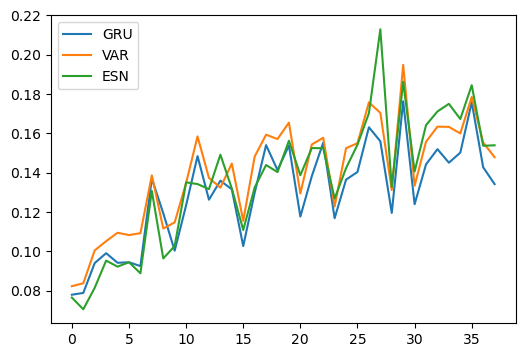

In [12]:
MSE_GRU = np.sqrt(np.mean(np.square(GRU_predict - GRU_truth), axis = 0))
MSE_VAR = np.sqrt(np.mean(np.square(VAR_predict - VAR_truth), axis = 0))
MSE_ESN = np.sqrt(np.mean(np.square(ESN_predict - ESN_truth), axis = 0))
print("GRU: ", f"{np.mean(MSE_GRU):.6f}")
print("VAR: ", f"{np.mean(MSE_VAR):.6f}")
print("ESN: ", f"{np.mean(MSE_ESN):.6f}")
plt.figure(figsize = (6,4))
plt.plot(MSE_GRU, label = "GRU")
plt.plot(MSE_VAR, label = "VAR")
plt.plot(MSE_ESN, label = "ESN")
plt.legend()
plt.show()

In [13]:
mode = 0
time_window = -1

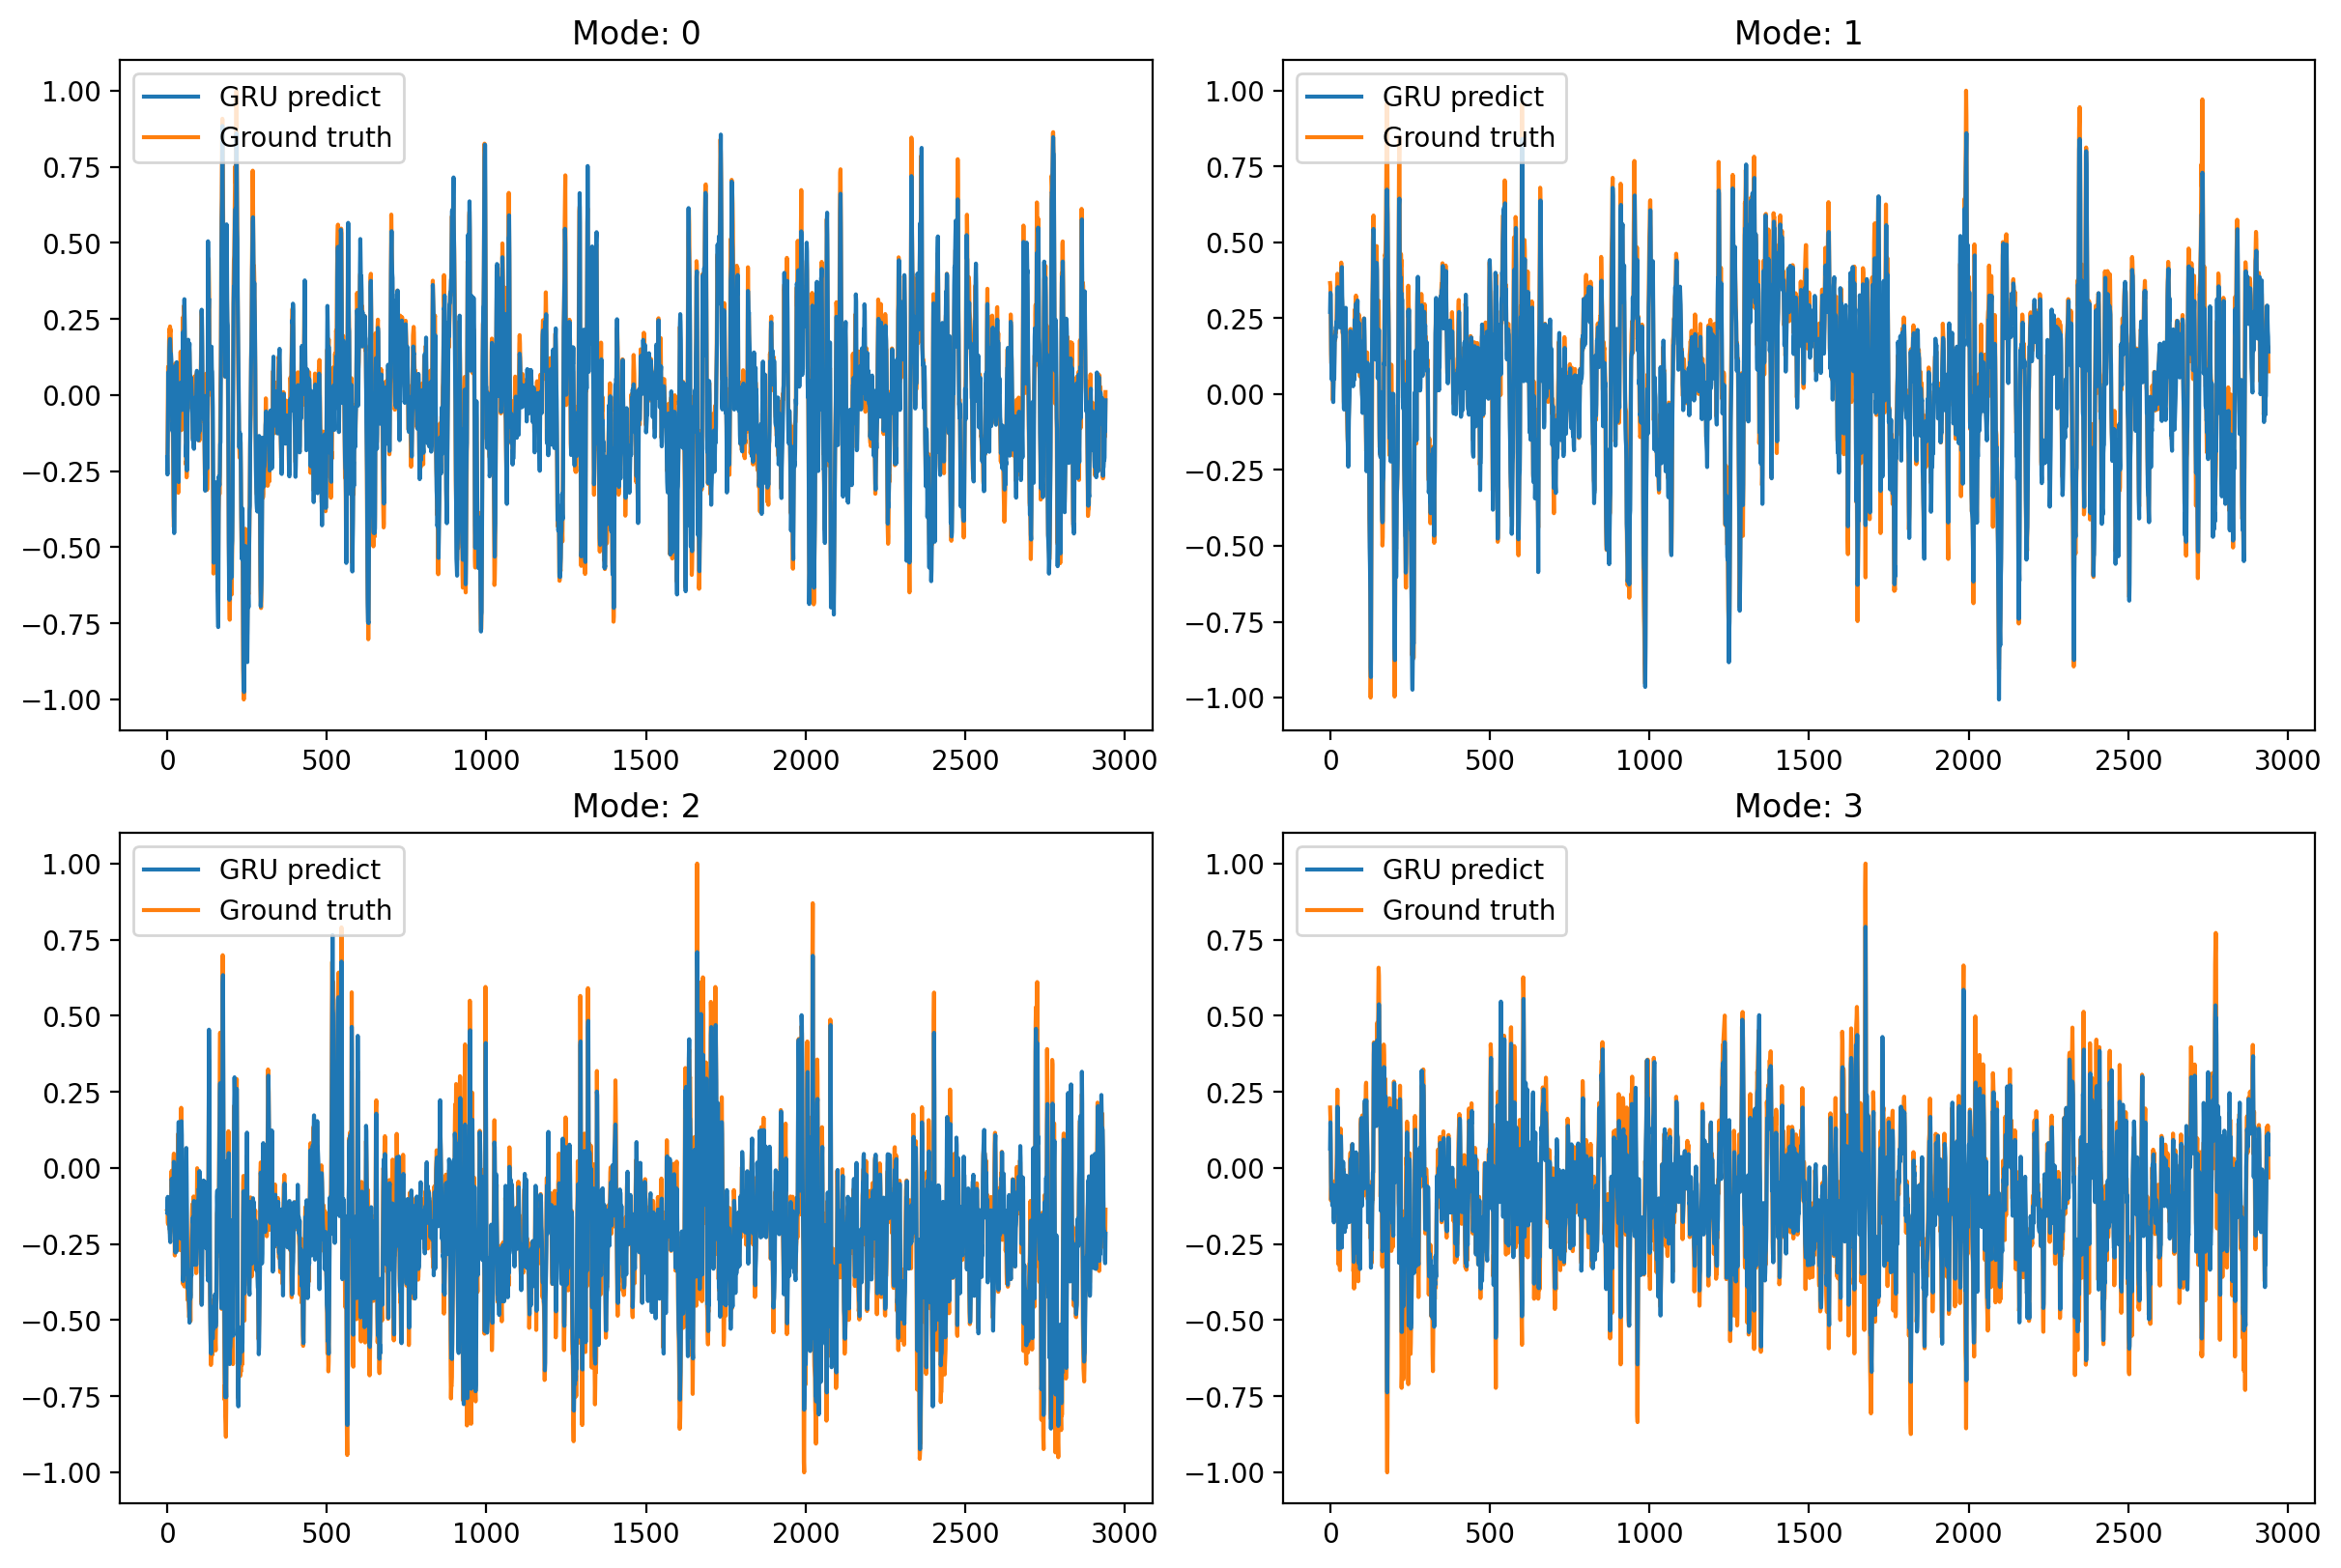

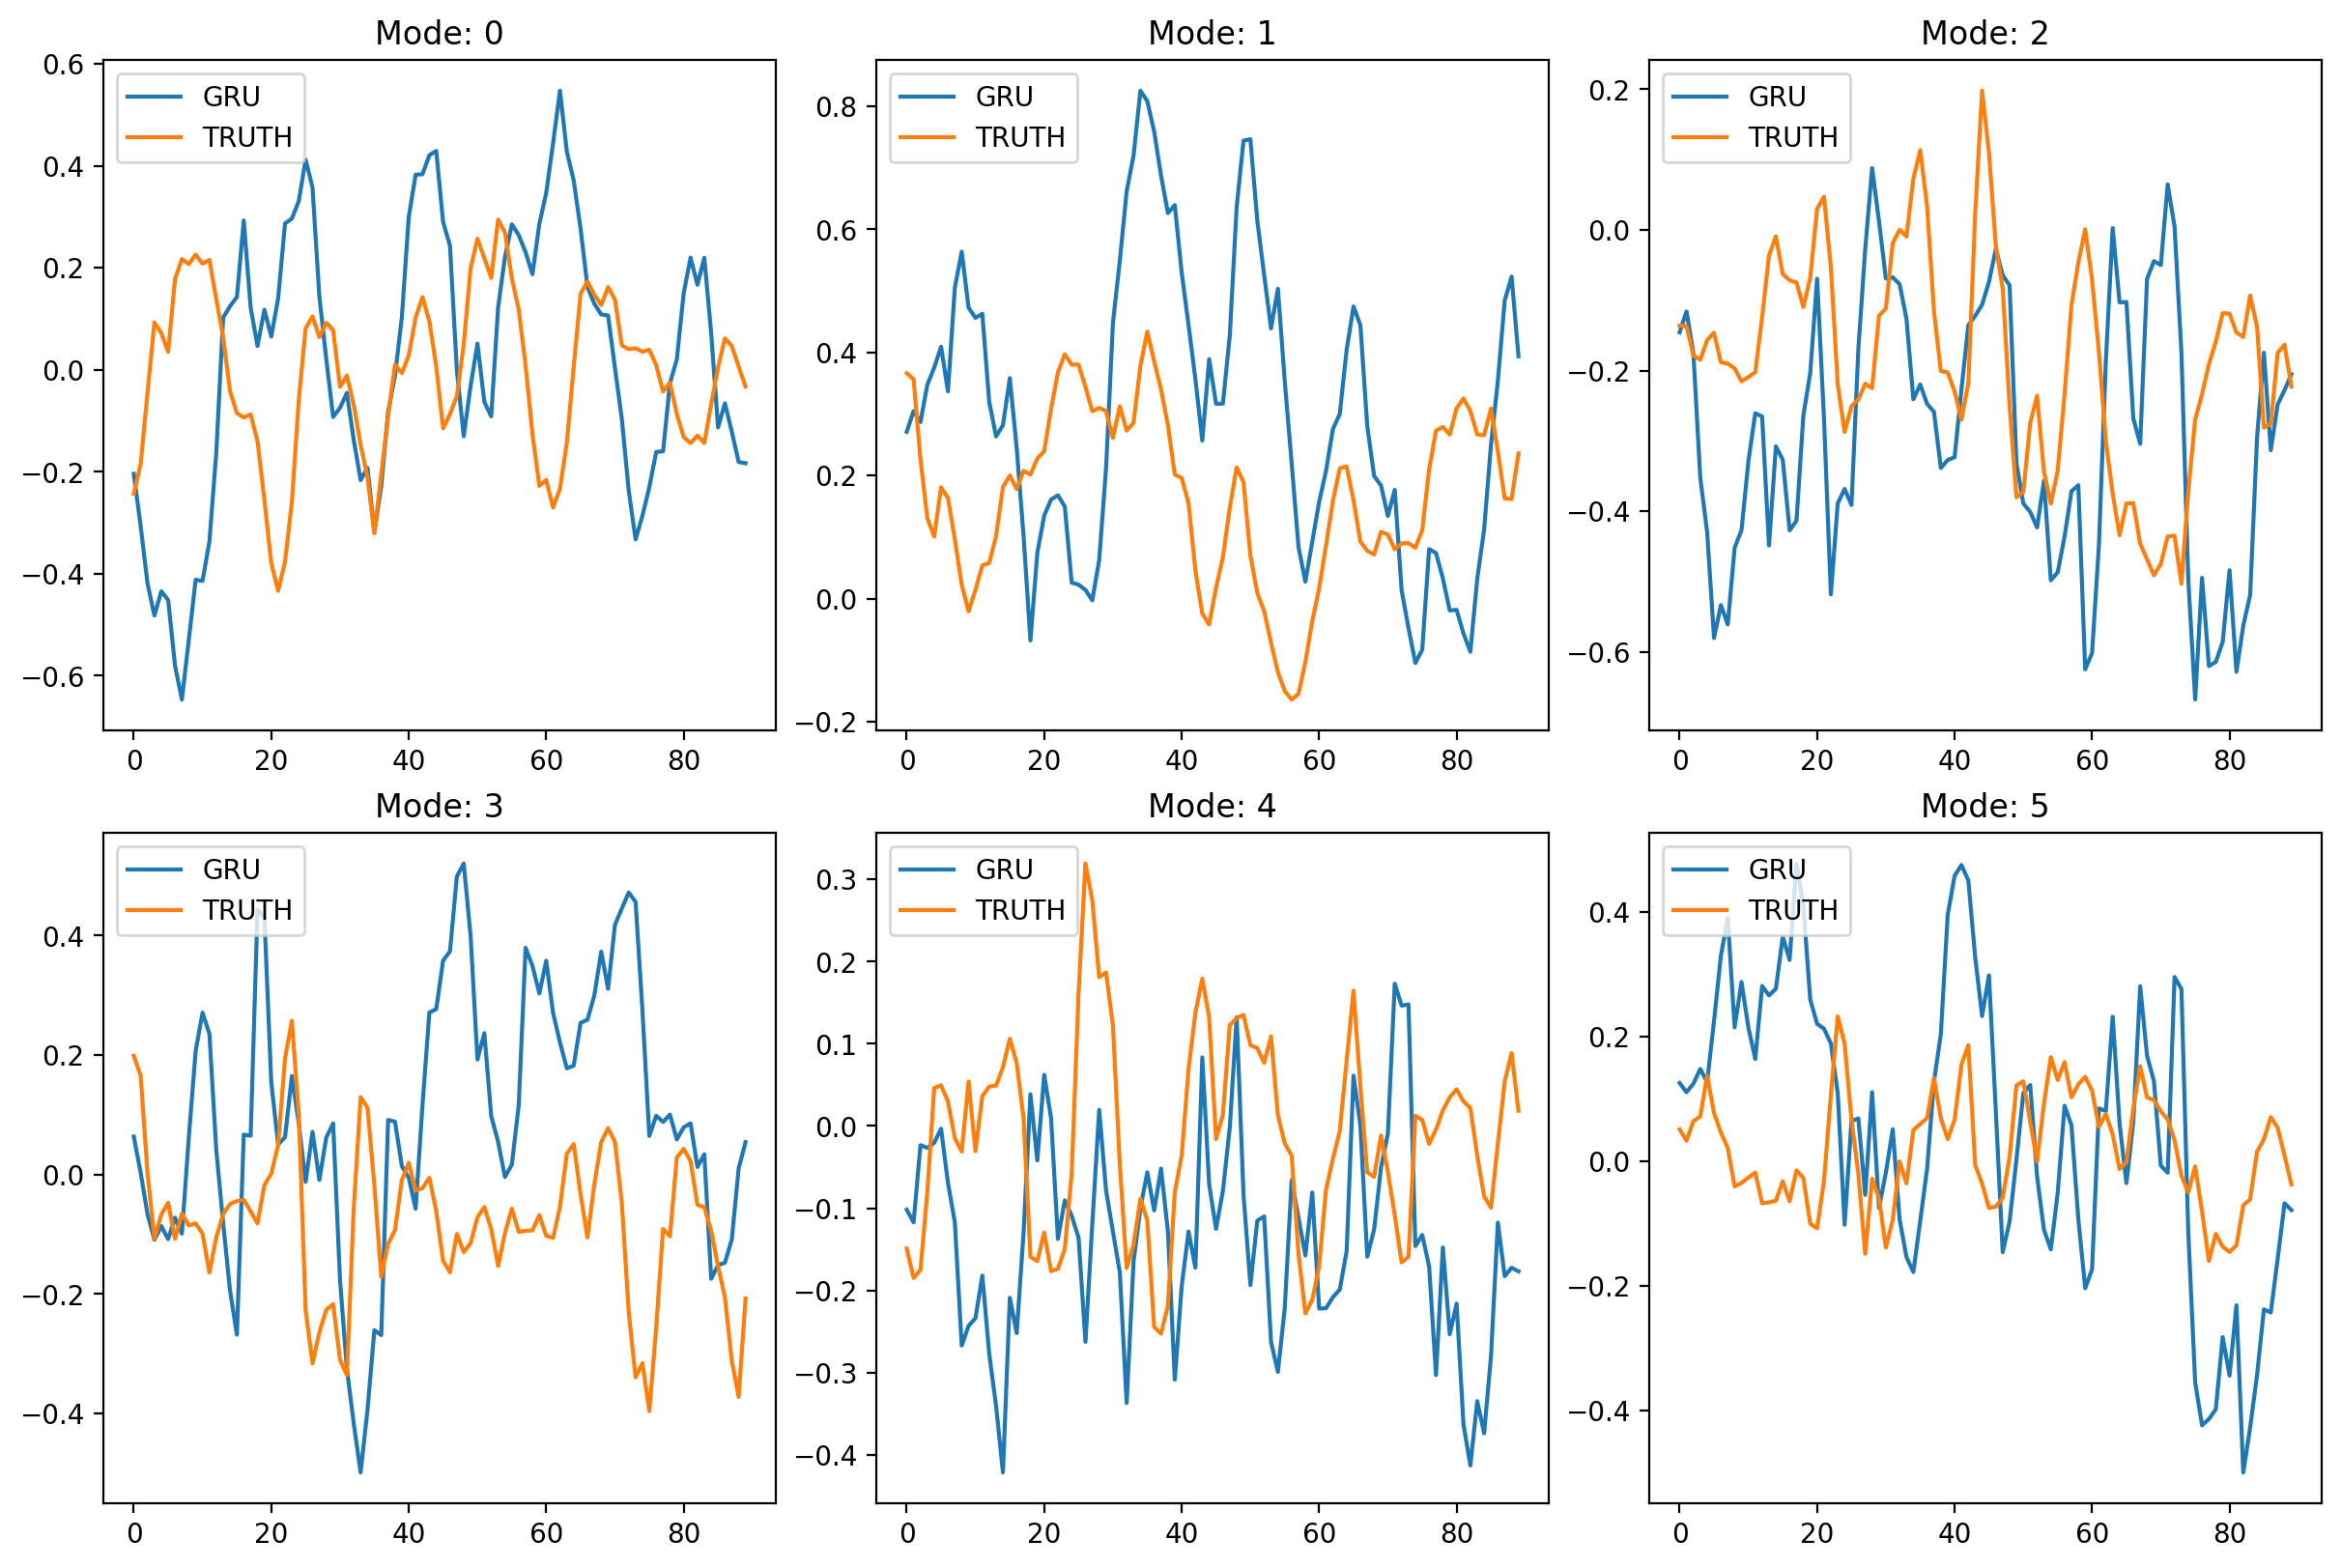

In [14]:
os.chdir(config["Path_img"])
fig, axes = plt.subplots(nrows = 2,
                         ncols = 2, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(GRU_predict[:time_window,i], label = "GRU predict", zorder = 3)
    ax.plot(GRU_truth[:time_window,i], label = "Ground truth")
    ax.set_title(f"Mode: {i}")
    ax.legend(loc = 2)
plt.savefig("GRU_Iter.png")
plt.show()

fig, axes = plt.subplots(nrows = 2,
                         ncols = 3, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(GRU_forecast[:,i], label = "GRU")
    ax.plot(test_set[config["ML_hyperparam_lookback"]:config["ML_hyperparam_lookback"]+config["ML_hyperparam_forecast_step"],i], label = "TRUTH")
    ax.set_title(f"Mode: {i}")
    ax.legend(loc = 2)
plt.savefig("GRU_Gen.png")
plt.show()

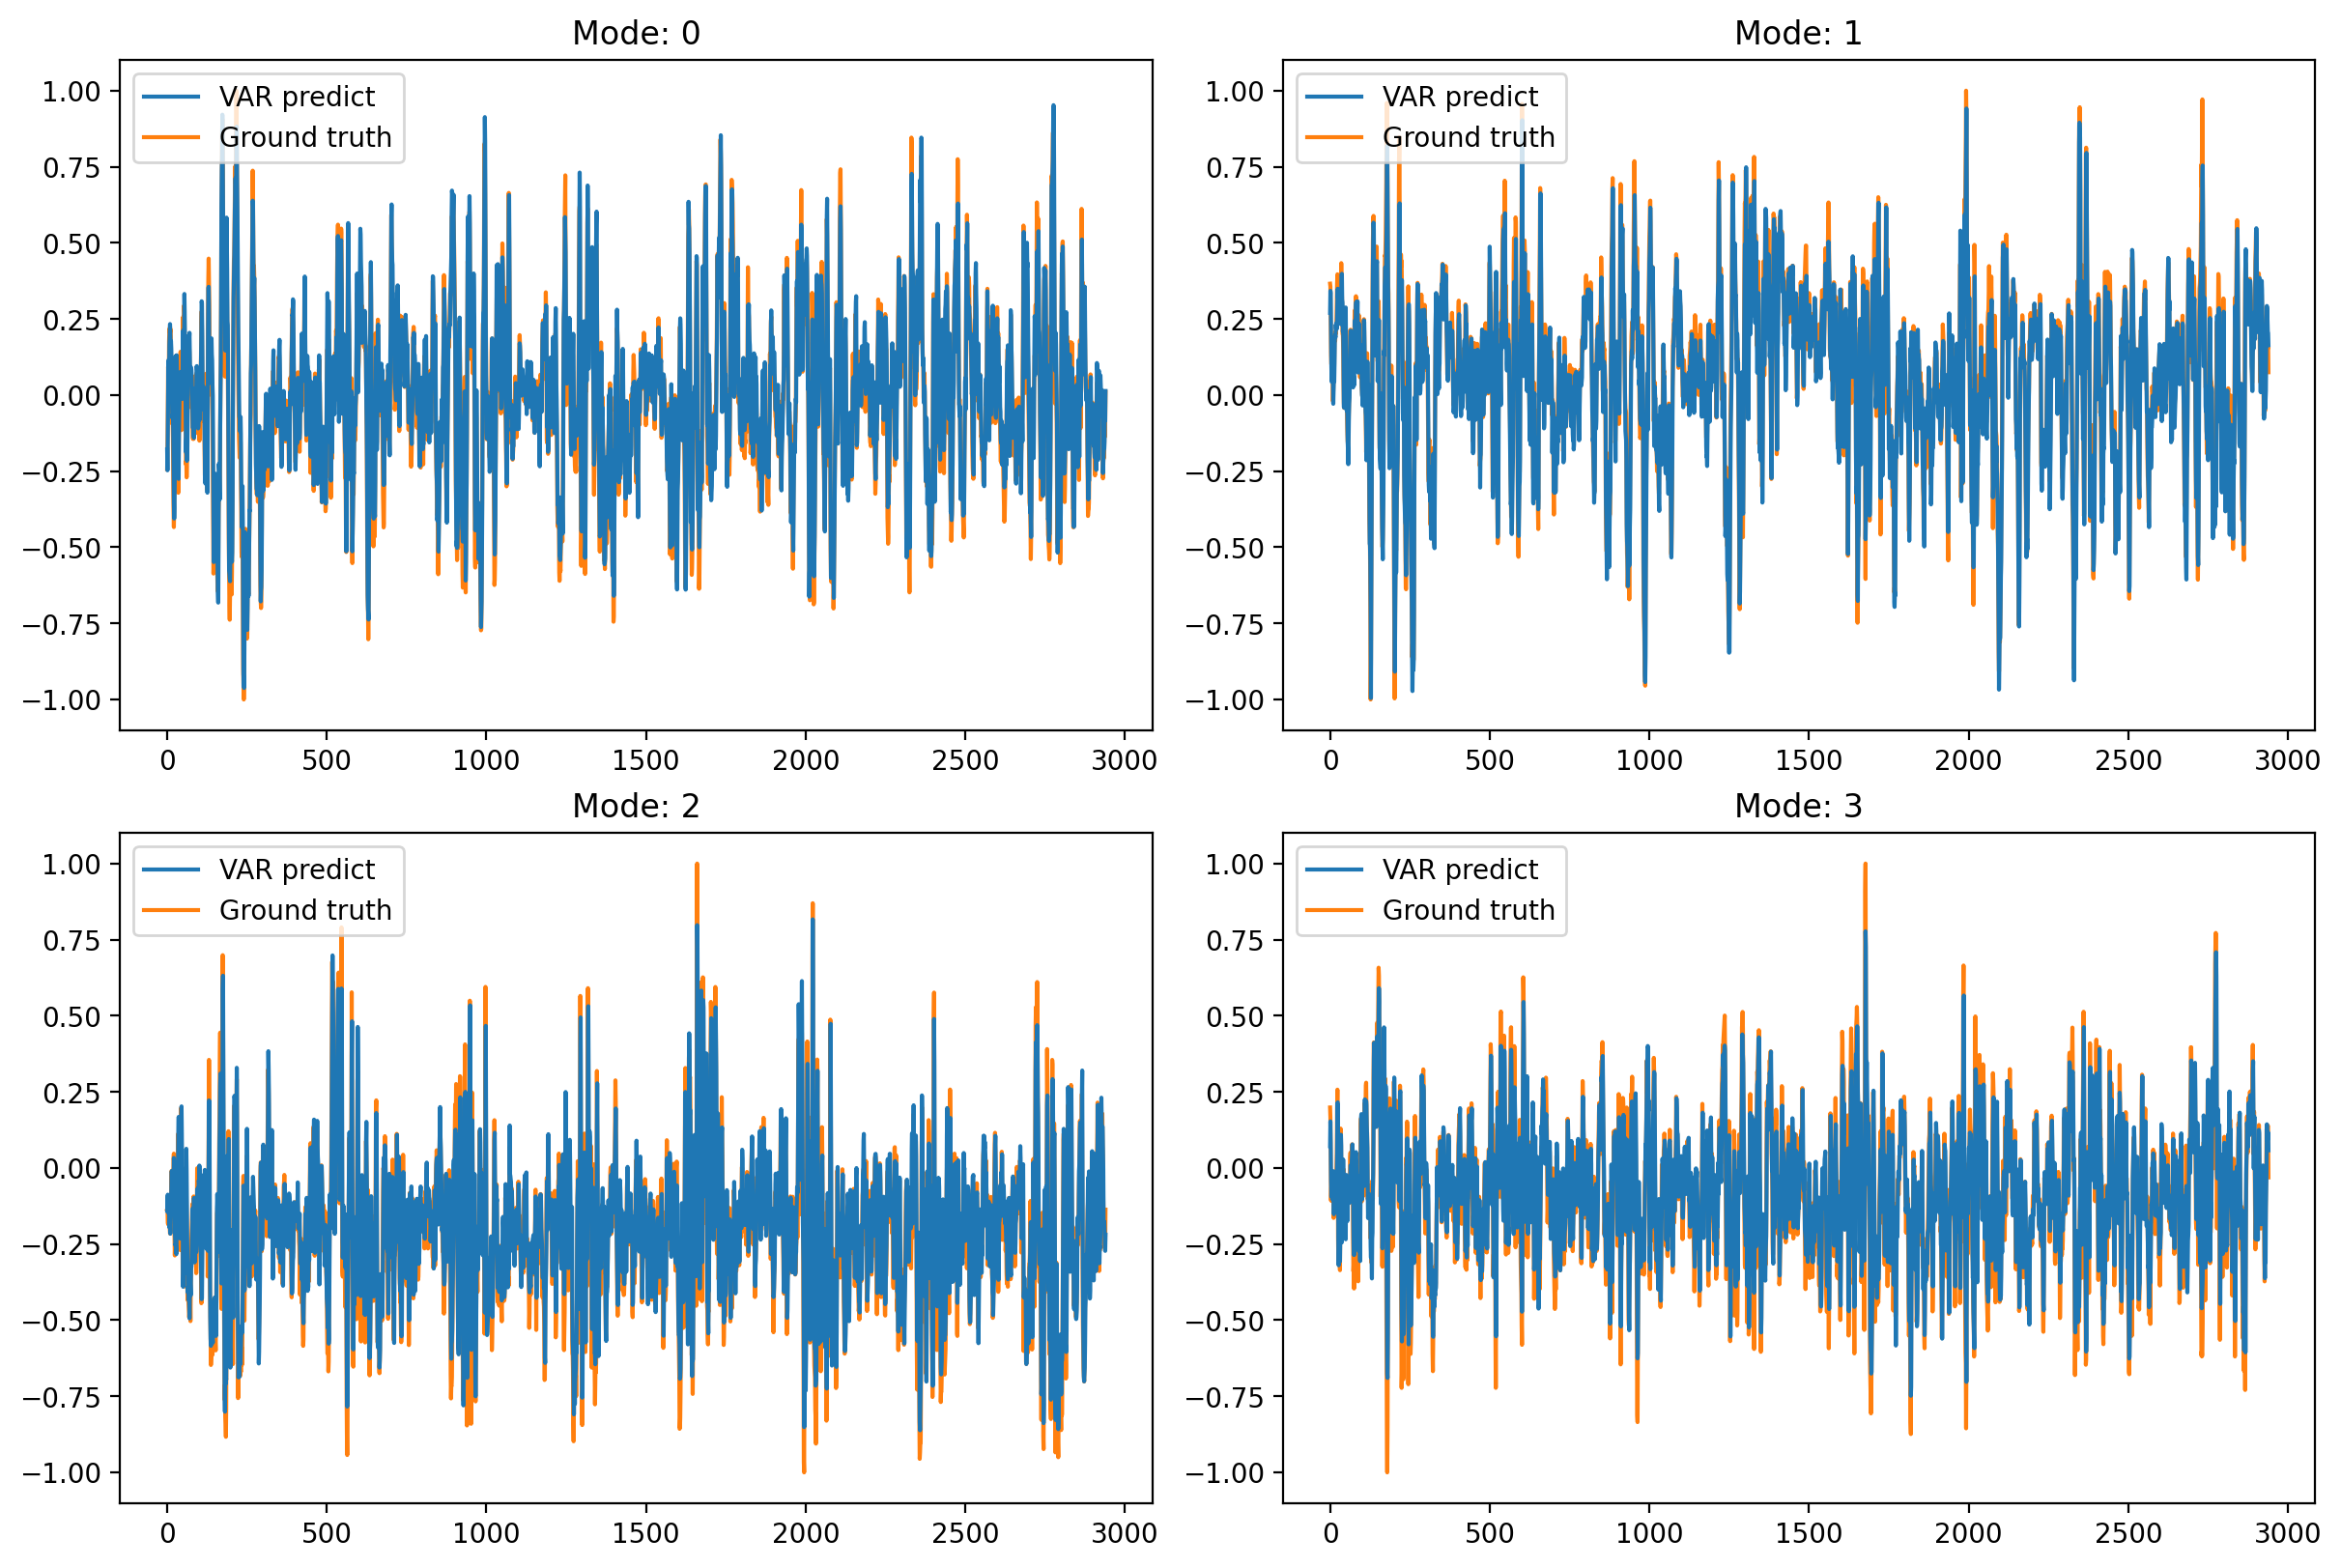

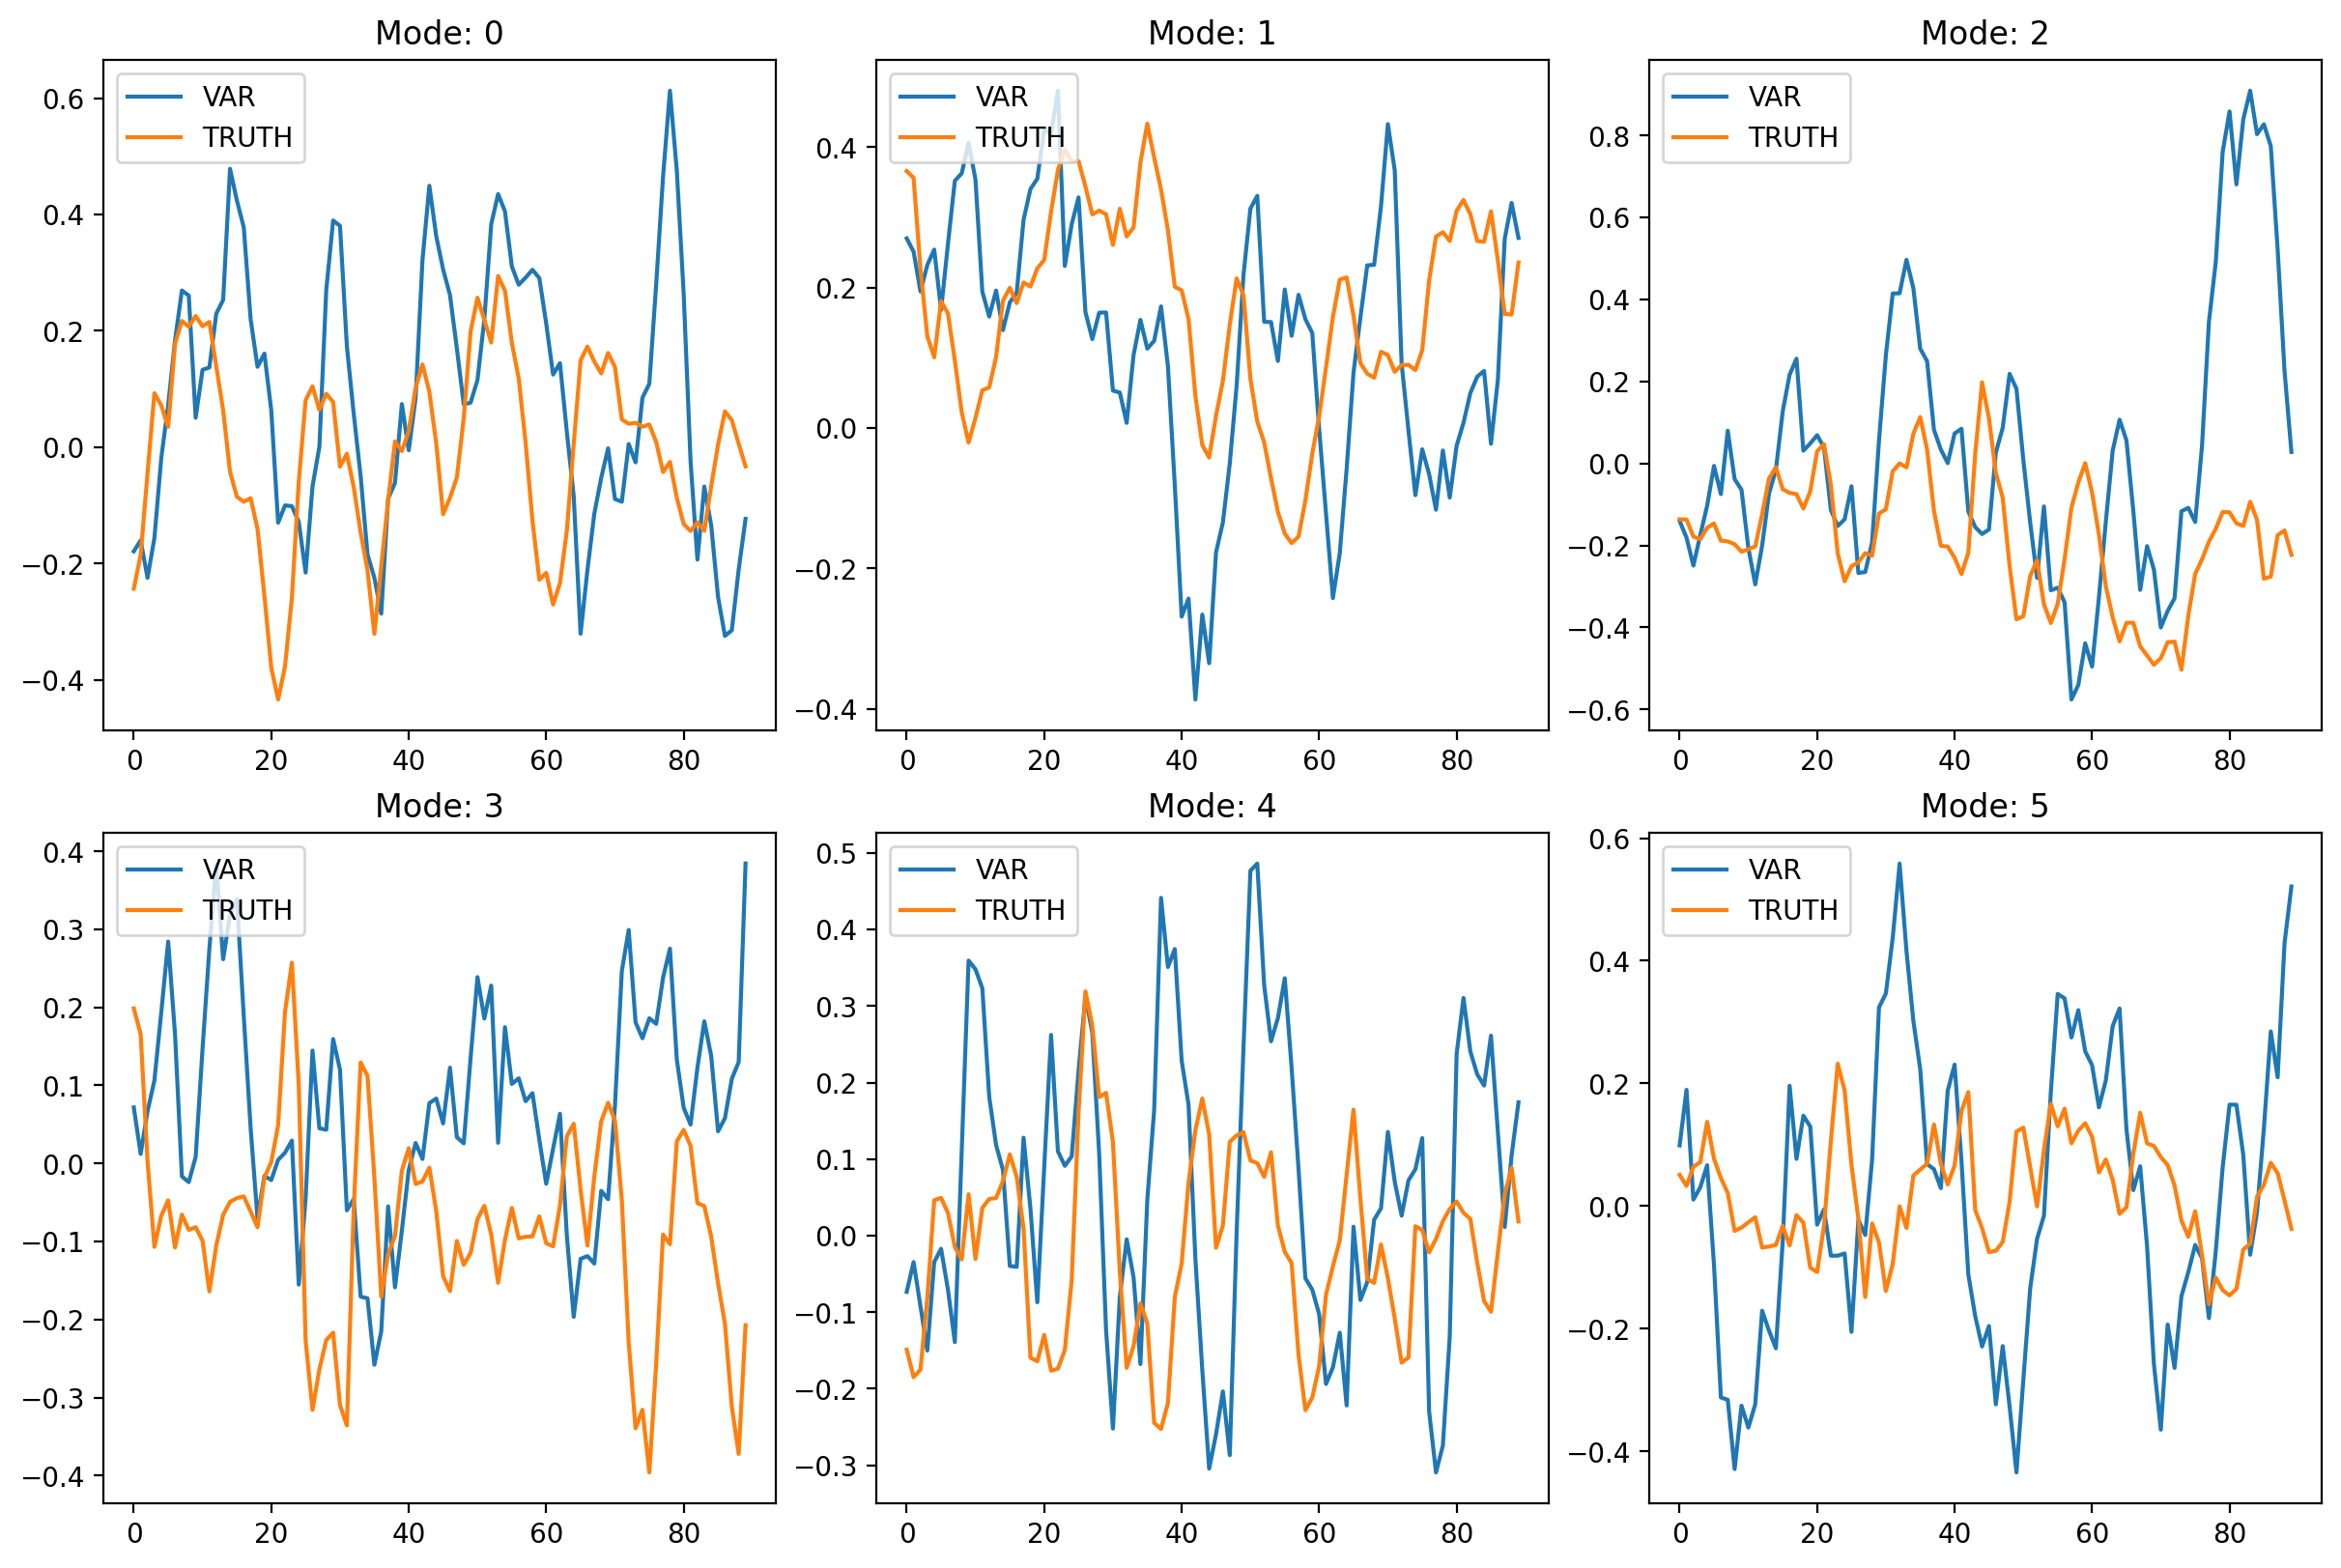

In [15]:
os.chdir(config["Path_img"])
fig, axes = plt.subplots(nrows = 2,
                         ncols = 2, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(VAR_predict[:time_window,i], label = "VAR predict", zorder = 3)
    ax.plot(VAR_truth[:time_window,i], label = "Ground truth")
    ax.set_title(f"Mode: {i}")
    ax.legend(loc = 2)
plt.savefig("VAR_Iter.png")
plt.show()

fig, axes = plt.subplots(nrows = 2,
                         ncols = 3, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(VAR_forecast[:,i], label = "VAR")
    ax.plot(test_set[config["ML_hyperparam_lookback"]:config["ML_hyperparam_lookback"]+config["ML_hyperparam_forecast_step"],i], label = "TRUTH")
    ax.set_title(f"Mode: {i}")
    ax.legend(loc = 2)
plt.savefig("VAR_Gen.png")
plt.show()

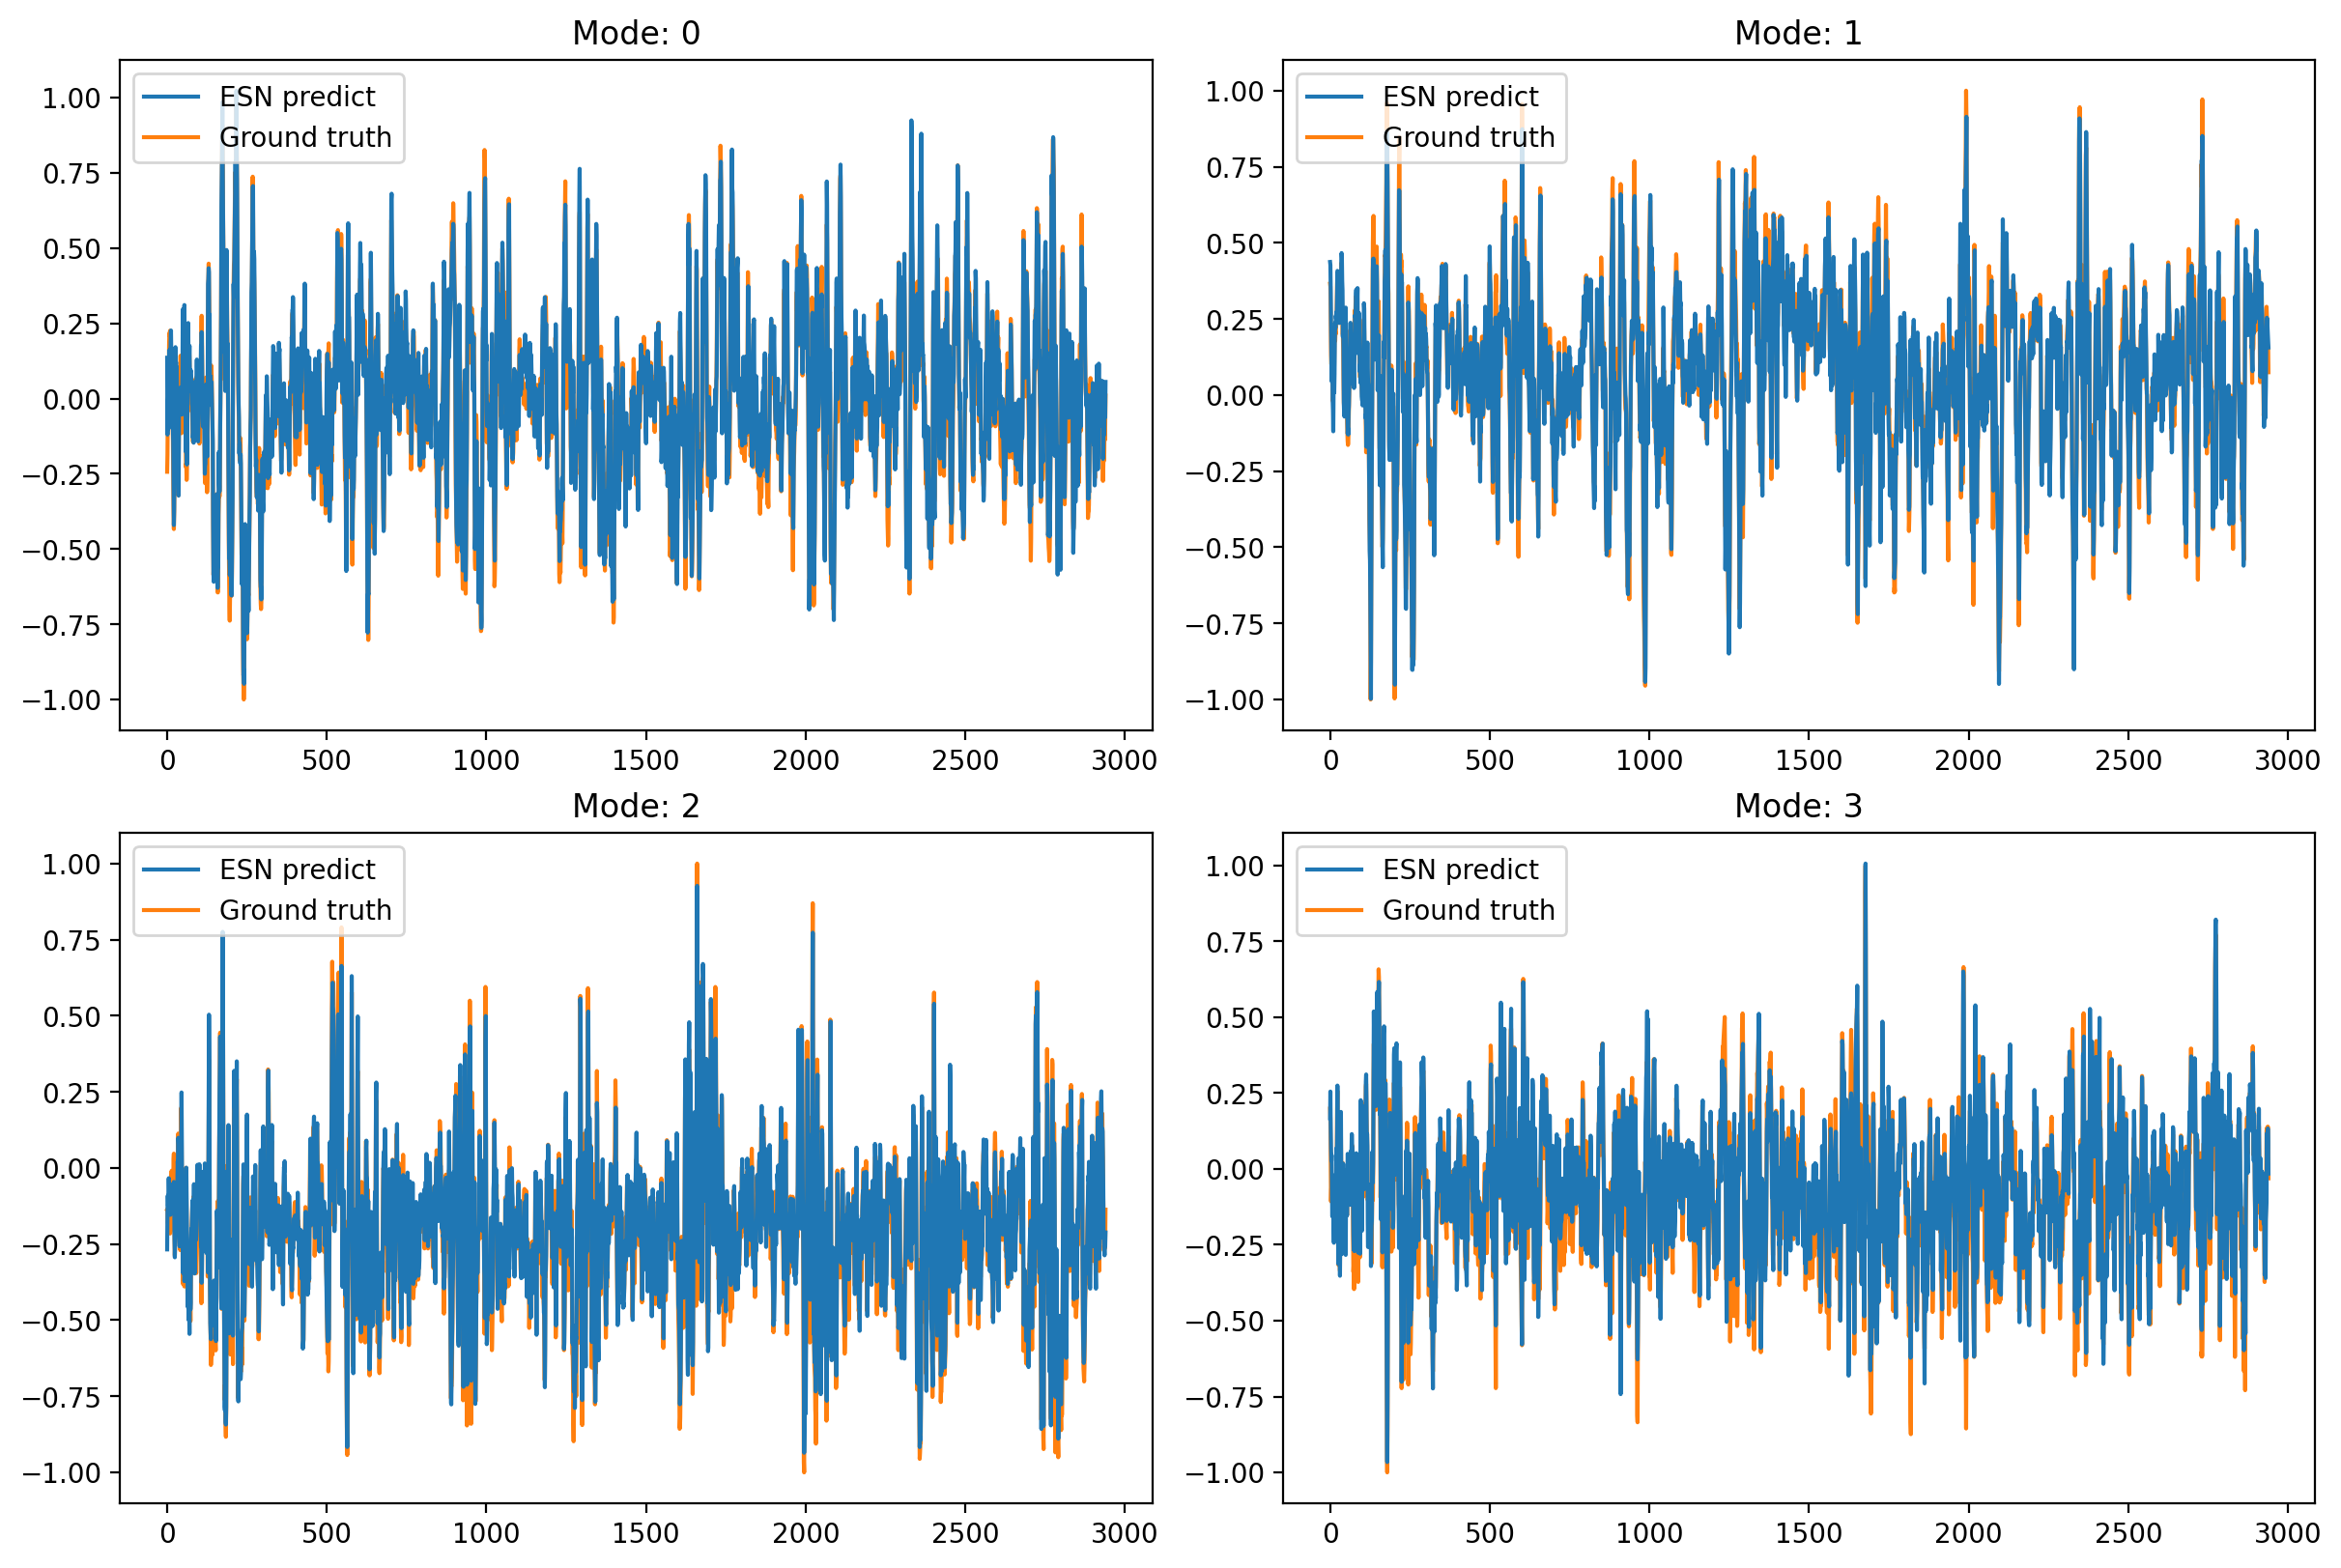

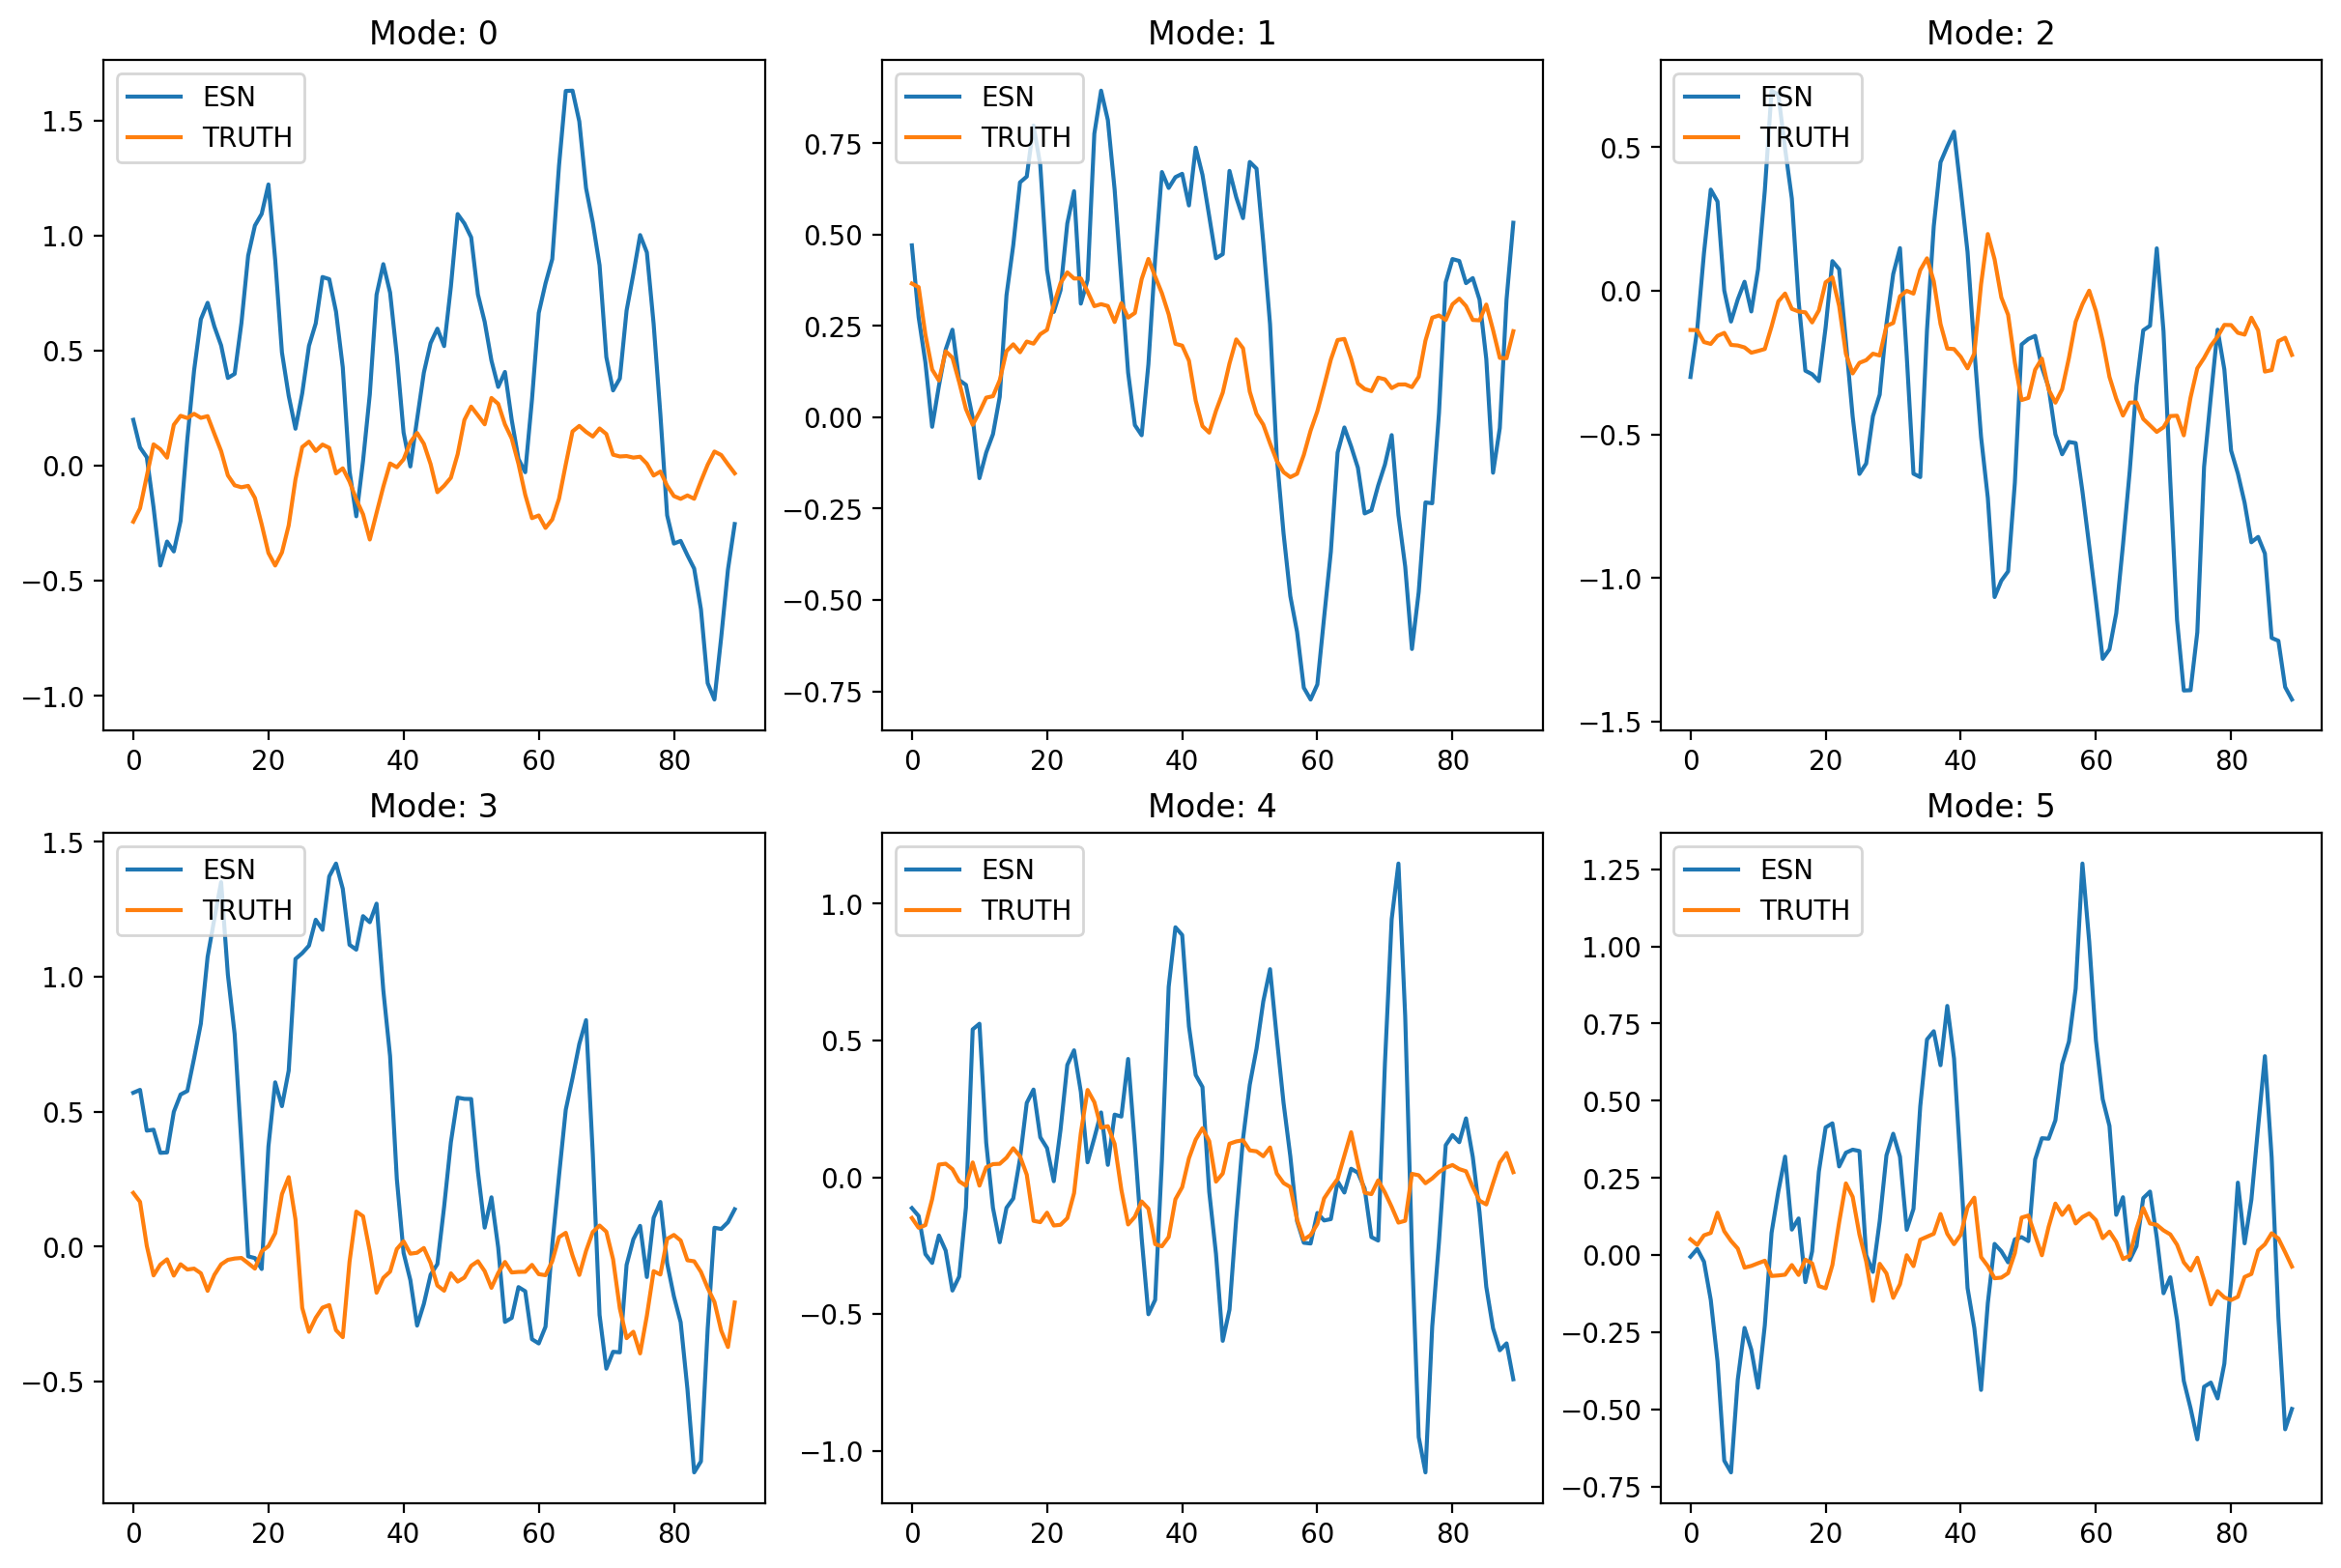

In [16]:
os.chdir(config["Path_img"])
fig, axes = plt.subplots(nrows = 2,
                         ncols = 2, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(ESN_predict[:time_window,i], label = "ESN predict", zorder = 3)
    ax.plot(ESN_truth[:time_window,i], label = "Ground truth")
    ax.set_title(f"Mode: {i}")
    ax.legend(loc = 2)
plt.savefig("ESN_Iter.png")    
plt.show()

fig, axes = plt.subplots(nrows = 2,
                         ncols = 3, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(ESN_forecast[:,i], label = "ESN")
    ax.plot(test_set[config["ML_hyperparam_lookback"]:config["ML_hyperparam_lookback"]+config["ML_hyperparam_forecast_step"],i], label = "TRUTH")
    ax.set_title(f"Mode: {i}")
    ax.legend(loc = 2)
plt.savefig("ESN_Gen.png")
plt.show()